# Install and import libraries

In [1]:
!pip install scikit-learn-intelex
!pip install clustering-benchmarks
!pip install pyclustering

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 107.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 110.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 40.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395106 sha256=c0143cf5159c929d95b4257c7dc601e1a64b5e117245301d7d90ccf2338a0cfa
  Stored in di

In [14]:
import clustbench
import matplotlib.pyplot as plt
import os.path
from sklearn.preprocessing import StandardScaler
import sklearn.cluster
import sklearn.mixture
import scipy.cluster
from pyclustering.cluster import *
import sklearn.datasets
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_palette('Paired', 12)
sns.set_color_codes()

In [3]:
#from sklearnex import patch_sklearn

#patch_sklearn()

# Template for benchmark function (https://hdbscan.readthedocs.io/en/latest/performance_and_scalability.html)

In [ ]:
def benchmark_algorithm(dataset_sizes, cluster_function, function_args, function_kwds,
                        dataset_dimension=10, dataset_n_clusters=10, max_time=45, sample_size=2):

    # Initialize the result with NaNs so that any unfilled entries
    # will be considered NULL when we convert to a pandas dataframe at the end
    result = np.nan * np.ones((len(dataset_sizes), sample_size))
    for index, size in enumerate(dataset_sizes):
        for s in range(sample_size):
            # Use sklearns make_blobs to generate a random dataset with specified size
            # dimension and number of clusters
            data, labels = sklearn.datasets.make_blobs(n_samples=size,
                                                       n_features=dataset_dimension,
                                                       centers=dataset_n_clusters)
            print("Fitting "+str(cluster_function)+" for "+str(size)+" data points")
            # Start the clustering with a timer
            start_time = time.time()
            cluster_function(data, *function_args, **function_kwds)
            time_taken = time.time() - start_time
            print("Done fitting")
            # If we are taking more than max_time then abort -- we don't
            # want to spend excessive time on slow algorithms
            if time_taken > max_time:
                result[index, s] = time_taken
                return pd.DataFrame(np.vstack([dataset_sizes.repeat(sample_size),
                                               result.flatten()]).T, columns=['x','y'])
            else:
                result[index, s] = time_taken

    # Return the result as a dataframe for easier handling with seaborn afterwards
    return pd.DataFrame(np.vstack([dataset_sizes.repeat(sample_size),
                                   result.flatten()]).T, columns=['x','y'])

# Comparison of scalability of different kmeans implementations

In [ ]:
from pyclustering.cluster.kmeans import kmeans
def benchmark_kmeans(dataset_sizes, cluster_function, function_args, function_kwds, plusplus=False, dataset_dimension=10, dataset_n_clusters=10, max_time=45, sample_size=2):

    # Initialize the result with NaNs so that any unfilled entries
    # will be considered NULL when we convert to a pandas dataframe at the end
    result = np.nan * np.ones((len(dataset_sizes), sample_size))
    for index, size in enumerate(dataset_sizes):
        for s in range(sample_size):
            # Use sklearns make_blobs to generate a random dataset with specified size
            # dimension and number of clusters
            data, labels = sklearn.datasets.make_blobs(n_samples=size,
                                                       n_features=dataset_dimension,
                                                       centers=dataset_n_clusters)
            # Pyclustering package needs special handling
            if "pyclustering" in str(cluster_function):
              # Initilise centres
              if plusplus:
                centres=pyclustering.cluster.center_initializer.kmeans_plusplus_initializer(data, dataset_n_clusters).initialize()
              else:
                centres=pyclustering.cluster.center_initializer.random_center_initializer(data, dataset_n_clusters).initialize()
              print("Fitting "+str(cluster_function)+" for "+str(size)+" data points")
              # Start the clustering with a timer
              start_time = time.time()
              instance=cluster_function(data, centres, *function_args, **function_kwds)
              instance.process()
              time_taken = time.time() - start_time
              print("Done fitting")
            else:
              print("Fitting "+str(cluster_function)+" for "+str(size)+" data points")
              # Start the clustering with a timer
              start_time = time.time()
              cluster_function(data, *function_args, **function_kwds)
              time_taken = time.time() - start_time
              print("Done fitting")
            # If we are taking more than max_time then abort -- we don't
            # want to spend excessive time on slow algorithms
            if time_taken > max_time:
                result[index, s] = time_taken
                return pd.DataFrame(np.vstack([dataset_sizes.repeat(sample_size),
                                               result.flatten()]).T, columns=['x','y'])
            else:
                result[index, s] = time_taken

    # Return the result as a dataframe for easier handling with seaborn afterwards
    return pd.DataFrame(np.vstack([dataset_sizes.repeat(sample_size),
                                   result.flatten()]).T, columns=['x','y'])


In [ ]:
huge_dataset_sizes=np.arange(1,11) * 100000

sklearn_kmeans = benchmark_kmeans(huge_dataset_sizes, sklearn.cluster.KMeans(10, init="random", n_init=1).fit, (), {}, sample_size=5)

scipy_kmeans = benchmark_kmeans(huge_dataset_sizes, scipy.cluster.vq.kmeans2, (10, ), {"minit":"random"}, sample_size=5)

pyclustering_kmeans = benchmark_kmeans(huge_dataset_sizes, pyclustering.cluster.kmeans.kmeans, (), {}, sample_size=5)

sklearn_kmeanspp = benchmark_kmeans(huge_dataset_sizes, sklearn.cluster.KMeans(10, init="k-means++", n_init=1).fit, (), {}, sample_size=5)

scipy_kmeanspp = benchmark_kmeans(huge_dataset_sizes, scipy.cluster.vq.kmeans2, (10, ), {"minit":"++"}, sample_size=5)

pyclustering_kmeanspp = benchmark_kmeans(huge_dataset_sizes, pyclustering.cluster.kmeans.kmeans, (), {}, plusplus=True, sample_size=5)


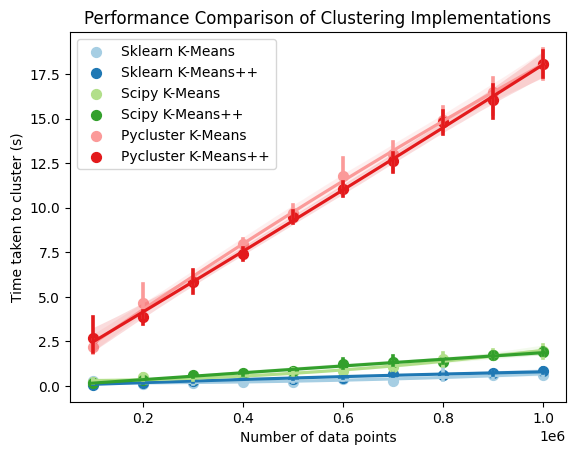

In [ ]:
sns.regplot(x='x', y='y', data=sklearn_kmeans, order=2, label='Sklearn K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=sklearn_kmeanspp, order=2, label='Sklearn K-Means++', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=scipy_kmeans, order=2, label='Scipy K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=scipy_kmeanspp, order=2, label='Scipy K-Means++', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=pyclustering_kmeans, order=2, label='Pycluster K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=pyclustering_kmeanspp, order=2, label='Pycluster K-Means++', x_estimator=np.mean)
#plt.gca().axis([0, 200000, 0, 5])
plt.gca().set_xlabel('Number of data points')
plt.gca().set_ylabel('Time taken to cluster (s)')
plt.title('Performance Comparison of Clustering Implementations')
plt.legend()

# Comparison of sklearn algorithms

In [6]:
def benchmark_sklearn(dataset_sizes, cluster_function, function_args, function_kwds, plusplus=False, dataset_dimension=10, dataset_n_clusters=10, max_time=45, sample_size=2):

    # Initialize the result with NaNs so that any unfilled entries
    # will be considered NULL when we convert to a pandas dataframe at the end
    result = np.nan * np.ones((len(dataset_sizes), sample_size))
    for index, size in enumerate(dataset_sizes):
        for s in range(sample_size):
            # Use sklearns make_blobs to generate a random dataset with specified size
            # dimension and number of clusters
            data, labels = sklearn.datasets.make_blobs(n_samples=size,
                                                       n_features=dataset_dimension,
                                                       centers=dataset_n_clusters)

            print("Fitting "+str(cluster_function)+" for "+str(size)+" data points")
            # Start the clustering with a timer
            start_time = time.time()
            cluster_function(data, *function_args, **function_kwds)
            time_taken = time.time() - start_time
            print("Done fitting")
            # If we are taking more than max_time then abort -- we don't
            # want to spend excessive time on slow algorithms
            if time_taken > max_time:
                result[index, s] = time_taken
                return pd.DataFrame(np.vstack([dataset_sizes.repeat(sample_size),
                                               result.flatten()]).T, columns=['x','y'])
            else:
                result[index, s] = time_taken

    # Return the result as a dataframe for easier handling with seaborn afterwards
    return pd.DataFrame(np.vstack([dataset_sizes.repeat(sample_size),
                                   result.flatten()]).T, columns=['x','y'])


In [ ]:
# Define different dataset sizes
small_dataset_sizes=np.hstack([np.arange(1, 6) * 500, np.arange(3,7) * 1000, np.arange(4,17) * 2000])
big_dataset_sizes=np.arange(1,16) * 4000
large_dataset_sizes=np.arange(1,11) * 20000

# Fit algorithms
affinity = benchmark_sklearn(small_dataset_sizes, sklearn.cluster.AffinityPropagation().fit, (), {}, sample_size=5)

agglomerative = benchmark_sklearn(small_dataset_sizes, sklearn.cluster.AgglomerativeClustering(10).fit, (), {}, sample_size=5)

birch = benchmark_sklearn(small_dataset_sizes, sklearn.cluster.Birch().fit, (), {}, sample_size=5)

dbscan = benchmark_sklearn(small_dataset_sizes, sklearn.cluster.DBSCAN().fit, (), {}, sample_size=5)

kmeans = benchmark_sklearn(small_dataset_sizes, sklearn.cluster.KMeans(10, init="k-means++", n_init=1).fit, (), {}, sample_size=5)

bisecting_kmeans = benchmark_sklearn(small_dataset_sizes, sklearn.cluster.BisectingKMeans(10, init='k-means++', n_init=1).fit, (), {}, sample_size=5)

minibatch_kmeans = benchmark_sklearn(small_dataset_sizes, sklearn.cluster.MiniBatchKMeans(10, init="k-means++", n_init=1).fit, (), {}, sample_size=5)

meanshift = benchmark_sklearn(small_dataset_sizes, sklearn.cluster.MeanShift().fit, (), {}, sample_size=5)

optics = benchmark_sklearn(small_dataset_sizes, sklearn.cluster.OPTICS().fit, (), {}, sample_size=5)

spectral_clust = benchmark_sklearn(small_dataset_sizes, sklearn.cluster.SpectralClustering(10).fit, (), {}, sample_size=5)

spectral_biclut = benchmark_sklearn(small_dataset_sizes, sklearn.cluster.SpectralBiclustering(10).fit, (), {}, sample_size=5)

spectral_coclust = benchmark_sklearn(small_dataset_sizes, sklearn.cluster.SpectralCoclustering().fit, (), {}, sample_size=5)

gmm = benchmark_sklearn(small_dataset_sizes, sklearn.mixture.GaussianMixture(10).fit, (), {}, sample_size=5)

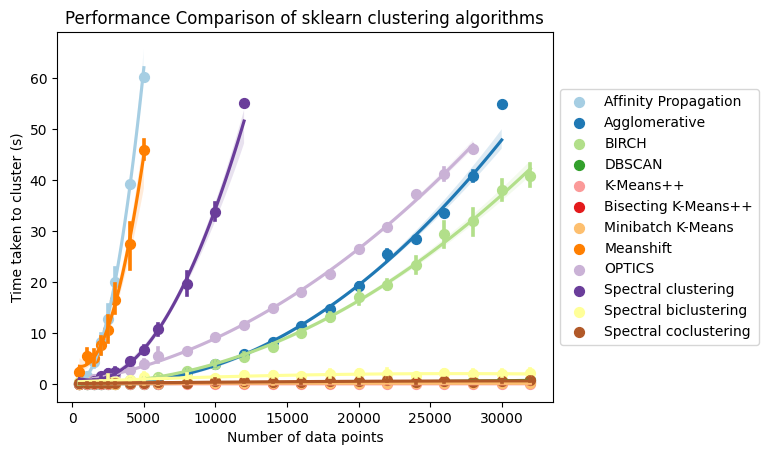

In [17]:
sns.regplot(x='x', y='y', data=affinity, order=2, label='Affinity Propagation', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=agglomerative, order=2, label='Agglomerative', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=birch, order=2, label='BIRCH', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=dbscan, order=2, label='DBSCAN', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=kmeans, order=2, label='K-Means++', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=bisecting_kmeans, order=2, label='Bisecting K-Means++', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=minibatch_kmeans, order=2, label='Minibatch K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=meanshift, order=2, label='Meanshift', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=optics, order=2, label='OPTICS', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=spectral_clust, order=2, label='Spectral clustering', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=spectral_biclut, order=2, label='Spectral biclustering', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=spectral_coclust, order=2, label='Spectral coclustering', x_estimator=np.mean)

#plt.gca().axis([0, 200000, 0, 5])
plt.gca().set_xlabel('Number of data points')
plt.gca().set_ylabel('Time taken to cluster (s)')
plt.title('Performance Comparison of sklearn clustering algorithms')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Comparison of accuracy of different algorithms (not finished)

In [ ]:
data_path = os.path.join("drive", 'MyDrive','Diss_project')
sklearn_methods=["KMeans"]
result={}
for battery in clustbench.get_battery_names(path=data_path):
  for dataset in clustbench.get_dataset_names(battery, path=data_path):
    # Load data
    data=clustbench.load_dataset(battery, dataset, path=data_path)
    # Standardise data
    scaled_data=StandardScaler().fit_transform(data.data)
    for algorithm in sklearn_methods:
      result[algorithm] = clustbench.fit_predict_many(getattr(sk, algorithm)(), scaled_data, data.n_clusters)


# sklearn plot example (for future plotting of clustering quality) https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

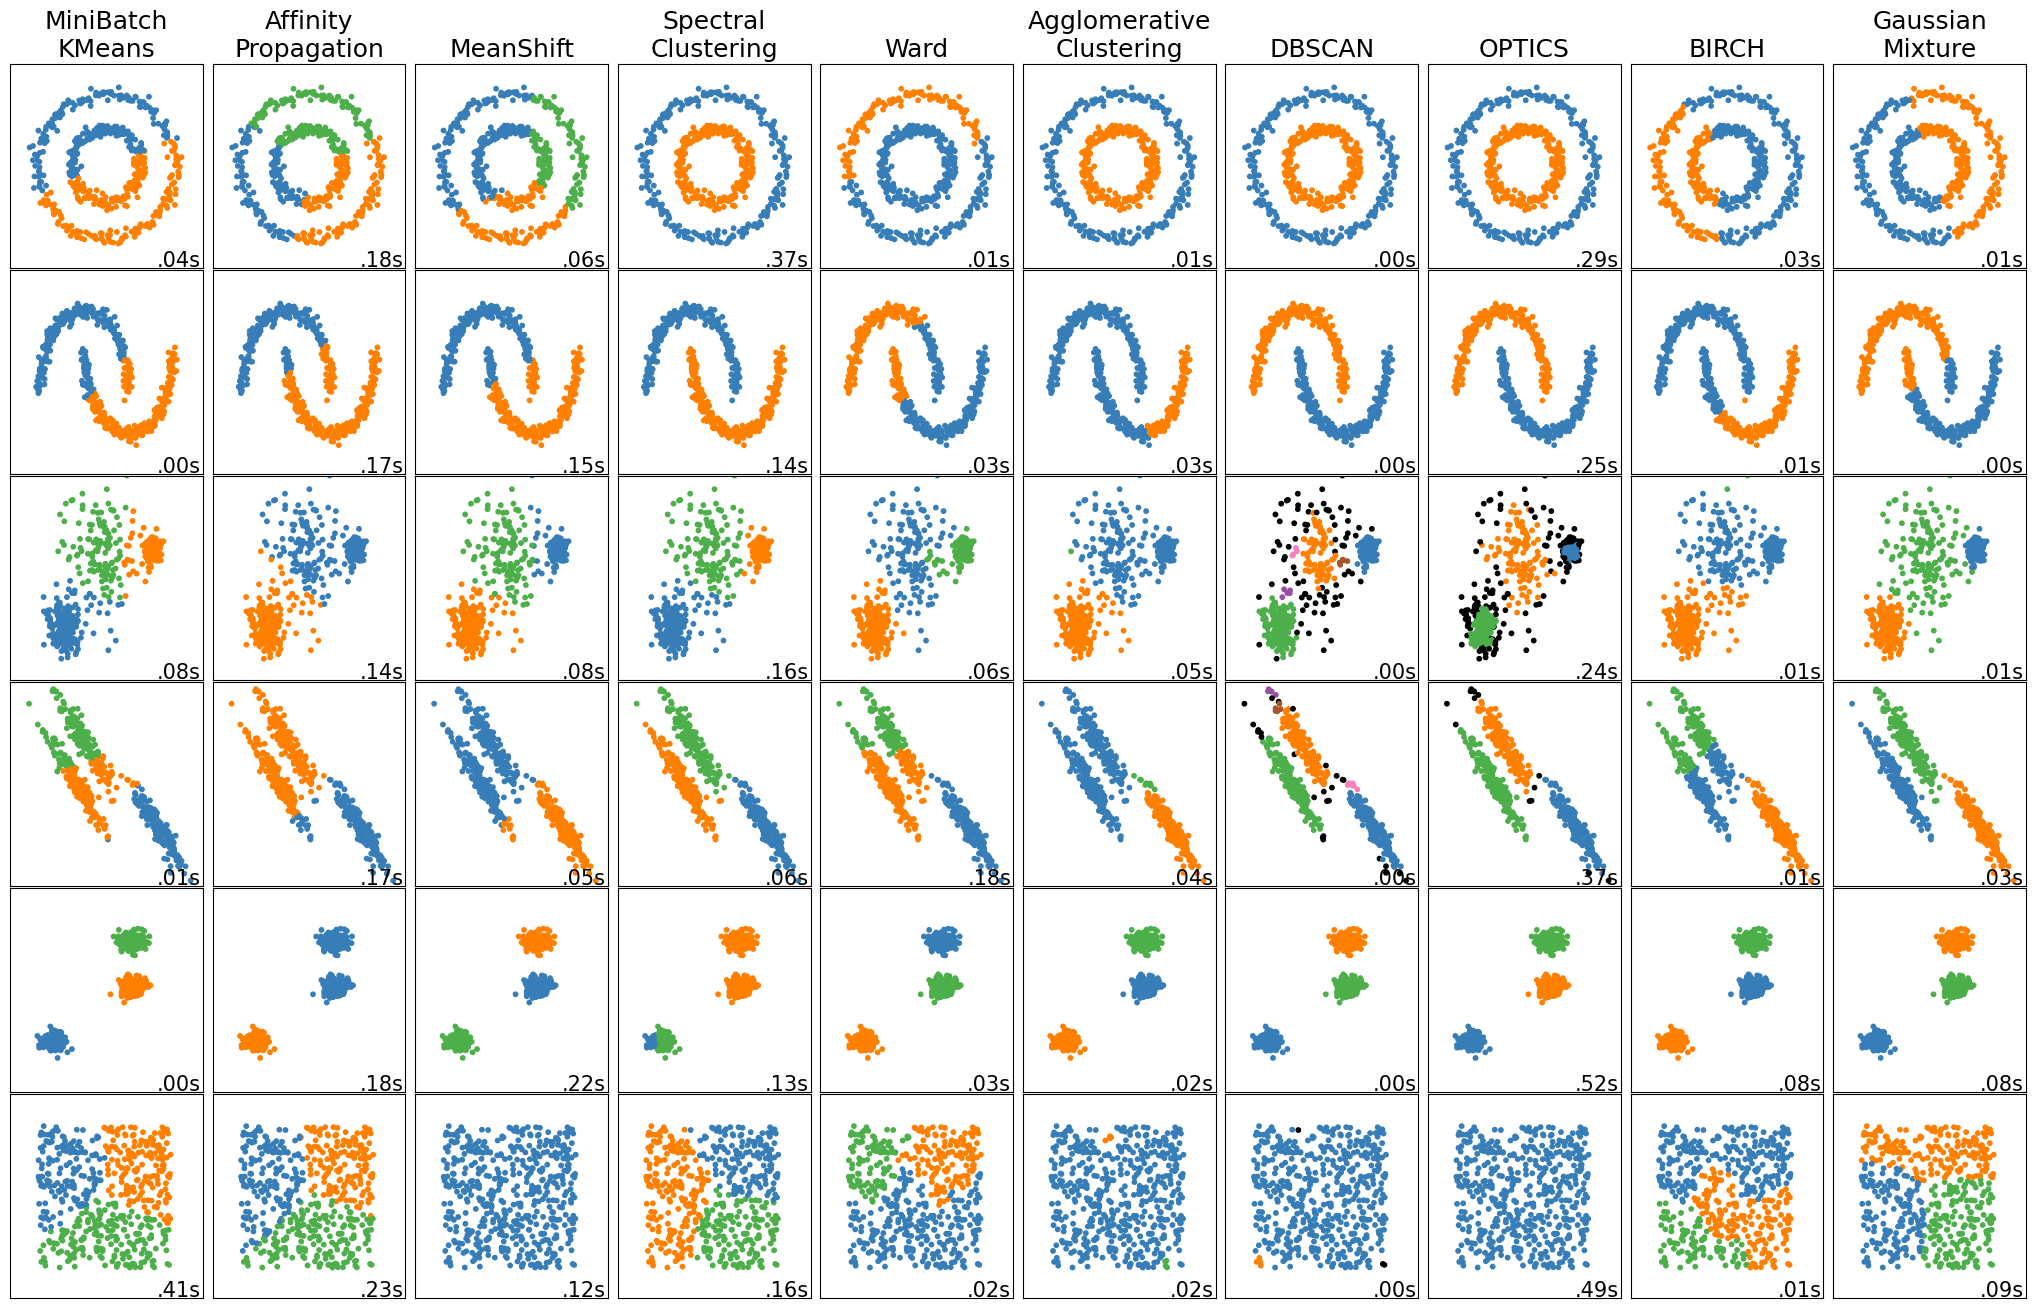

In [ ]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"], n_init="auto")
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=0
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

# example of gathering data through url and not locally (benchmark module)

In [ ]:
i=1
datasets_names={'fcps':['atom', 'chainlink', 'engytime', 'hepta', 'lsun', 'target', 'tetra', 'twodiamonds', 'wingnut'], 'g2mg':['g2mg_1_10', 'g2mg_1_20', 'g2mg_1_30', 'g2mg_1_40', 'g2mg_1_50', 'g2mg_1_60', 'g2mg_1_70', 'g2mg_1_80', 'g2mg_1_90', 'g2mg_2_10', 'g2mg_2_20', 'g2mg_2_30', 'g2mg_2_40', 'g2mg_2_50', 'g2mg_2_60', 'g2mg_2_70', 'g2mg_2_80', 'g2mg_2_90', 'g2mg_4_10', 'g2mg_4_20', 'g2mg_4_30', 'g2mg_4_40', 'g2mg_4_50', 'g2mg_4_60', 'g2mg_4_70', 'g2mg_4_80', 'g2mg_4_90', 'g2mg_8_10', 'g2mg_8_20', 'g2mg_8_30', 'g2mg_8_40', 'g2mg_8_50', 'g2mg_8_60', 'g2mg_8_70', 'g2mg_8_80', 'g2mg_8_90', 'g2mg_16_10', 'g2mg_16_20', 'g2mg_16_30', 'g2mg_16_40', 'g2mg_16_50', 'g2mg_16_60', 'g2mg_16_70', 'g2mg_16_80', 'g2mg_16_90', 'g2mg_32_10', 'g2mg_32_20', 'g2mg_32_30', 'g2mg_32_40', 'g2mg_32_50', 'g2mg_32_60', 'g2mg_32_70', 'g2mg_32_80', 'g2mg_32_90', 'g2mg_64_10', 'g2mg_64_20', 'g2mg_64_30', 'g2mg_64_40', 'g2mg_64_50', 'g2mg_64_60', 'g2mg_64_70', 'g2mg_64_80', 'g2mg_64_90', 'g2mg_128_10', 'g2mg_128_20', 'g2mg_128_30', 'g2mg_128_40', 'g2mg_128_50', 'g2mg_128_60', 'g2mg_128_70', 'g2mg_128_80', 'g2mg_128_90'], 'graves':['dense', 'fuzzyx', 'line', 'parabolic', 'ring', 'ring_noisy', 'ring_outliers', 'zigzag', 'zigzag_noisy', 'zigzag_outliers'], 'h2mg':['h2mg_1_10', 'h2mg_1_20', 'h2mg_1_30', 'h2mg_1_40', 'h2mg_1_50', 'h2mg_1_60', 'h2mg_1_70', 'h2mg_1_80', 'h2mg_1_90', 'h2mg_2_10', 'h2mg_2_20', 'h2mg_2_30', 'h2mg_2_40', 'h2mg_2_50', 'h2mg_2_60', 'h2mg_2_70', 'h2mg_2_80', 'h2mg_2_90', 'h2mg_4_10', 'h2mg_4_20', 'h2mg_4_30', 'h2mg_4_40', 'h2mg_4_50', 'h2mg_4_60', 'h2mg_4_70', 'h2mg_4_80', 'h2mg_4_90', 'h2mg_8_10', 'h2mg_8_20', 'h2mg_8_30', 'h2mg_8_40', 'h2mg_8_50', 'h2mg_8_60', 'h2mg_8_70', 'h2mg_8_80', 'h2mg_8_90', 'h2mg_16_10', 'h2mg_16_20', 'h2mg_16_30', 'h2mg_16_40', 'h2mg_16_50', 'h2mg_16_60', 'h2mg_16_70', 'h2mg_16_80', 'h2mg_16_90', 'h2mg_32_10', 'h2mg_32_20', 'h2mg_32_30', 'h2mg_32_40', 'h2mg_32_50', 'h2mg_32_60', 'h2mg_32_70', 'h2mg_32_80', 'h2mg_32_90', 'h2mg_64_10', 'h2mg_64_20', 'h2mg_64_30', 'h2mg_64_40', 'h2mg_64_50', 'h2mg_64_60', 'h2mg_64_70', 'h2mg_64_80', 'h2mg_64_90', 'h2mg_128_10', 'h2mg_128_20', 'h2mg_128_30', 'h2mg_128_40', 'h2mg_128_50', 'h2mg_128_60', 'h2mg_128_70', 'h2mg_128_80', 'h2mg_128_90'], 'mnist':['digits', 'fashion'], 'other':['chameleon_t4_8k', 'chameleon_t5_8k', 'chameleon_t7_10k', 'chameleon_t8_8k', 'hdbscan', 'iris', 'iris5', 'square'], 'sipu':['a1', 'a2', 'a3', 'aggregation', 'birch1', 'birch2', 'compound', 'd31', 'flame', 'jain', 'pathbased', 'r15', 's1', 's2', 's3', 's4', 'spiral', 'unbalance', 'worms_2', 'worms_64'], 'uci':['ecoli', 'glass', 'ionosphere', 'sonar', 'statlog', 'wdbc', 'wine', 'yeast'], 'wut':['circles', 'cross', 'graph', 'isolation', 'labirynth', 'mk1', 'mk2', 'mk3', 'mk4', 'olympic', 'smile', 'stripes', 'trajectories', 'trapped_lovers', 'twosplashes', 'windows', 'x1', 'x2', 'x3', 'z1', 'z2', 'z3']}
data_url="https://github.com/gagolews/clustering-data-v1/raw/v1.1.0"
for battery in datasets_names.keys():
  for dataset in datasets_names[battery]:
    data=clustbench.load_dataset(battery, dataset, url=data_url)
    print(i)
    i+=1


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
